In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import os
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics.pairwise import haversine_distances
import time
from scipy.optimize import linear_sum_assignment

import importlib
import meituan

In [2]:
base_path = '/home1/yongpeng/meituan_data/'

# waybill
waybill = pd.read_csv(os.path.join(base_path, 'all_waybill_info_meituan_0322.csv'))
time_cols = ['platform_order_time', 'order_push_time', 'dispatch_time', 'estimate_meal_prepare_time', 'estimate_arrived_time', 'grab_time', 'fetch_time', 'arrive_time']
for t_col in time_cols:
    waybill[t_col] = pd.to_datetime(waybill[t_col], unit='s')

waybill = waybill.sort_values(by=['courier_id','dispatch_time', 'order_id'])

# courier
courier = pd.read_csv(os.path.join(base_path, 'courier_wave_info_meituan.csv'))
for t_col in ['wave_start_time', 'wave_end_time']:
    courier[t_col] = pd.to_datetime(courier[t_col], unit='s')
    
# rider
rider = pd.read_csv(os.path.join(base_path, 'dispatch_rider_meituan.csv'))
rider['dispatch_time'] = pd.to_datetime(rider['dispatch_time'], unit='s')

# orders
orders = pd.read_csv(os.path.join(base_path, 'dispatch_waybill_meituan.csv'))
orders['dispatch_time'] = pd.to_datetime(orders['dispatch_time'], unit='s')

In [3]:
import meituan.pipeline.data
importlib.reload(meituan.pipeline.data)
from meituan.pipeline.data import upstream_pipeline, chunk_by_timeblocks, compare_chunk_id_overlap, haversine_distance_matrix


In [4]:
courier, orders = upstream_pipeline(waybill_df=waybill, save_folder='/home1/yongpeng/meituan_data/processed_data/base')

In [5]:
chunked_courier = chunk_by_timeblocks(df=courier,
                                    time_col='time',
                                    time_increment=pd.Timedelta('5min'),
                                    start_time=pd.to_datetime('2022-10-16 16:00:00')
                                     )

chunked_orders = chunk_by_timeblocks(df=orders,
                                    time_col='time',
                                    time_increment=pd.Timedelta('5min'),
                                    start_time=pd.to_datetime('2022-10-16 16:00:00')
                                     )

In [6]:
display(chunked_courier.head())
display(chunked_orders.head())

,dt,time,courier_id,grab_lng,grab_lat,is_weekend,timeblock,timeblock_start
101288,20221017,2022-10-16 16:03:18,4278,174.559879,45.863758,0,0,2022-10-16 16:00:00
101287,20221017,2022-10-16 16:01:46,1125,174.570278,45.907184,0,0,2022-10-16 16:00:00
52188,20221017,2022-10-16 16:00:48,247,174.556864,45.867384,1,0,2022-10-16 16:00:00
572298,20221017,2022-10-16 16:00:48,864,174.561019,45.895660,1,0,2022-10-16 16:00:00
333974,20221017,2022-10-16 16:04:48,3447,174.556816,45.895377,0,0,2022-10-16 16:00:00


,dt,time,order_id,sender_lng,sender_lat,da_id,poi_id,is_prebook,is_weekend,timeblock,timeblock_start
159926,20221017,2022-10-16 16:02:52,152946,174.568380,45.860310,7,3305,0,0,0,2022-10-16 16:00:00
101287,20221017,2022-10-16 16:01:46,98318,174.581294,45.887569,13,1812,0,0,0,2022-10-16 16:00:00
497512,20221017,2022-10-16 16:03:56,443599,174.577346,45.863190,0,578,0,0,0,2022-10-16 16:00:00
389483,20221017,2022-10-16 16:04:06,354359,174.579970,45.860080,0,1116,0,0,0,2022-10-16 16:00:00
245425,20221017,2022-10-16 16:02:51,230133,174.578231,45.890111,13,825,0,0,0,2022-10-16 16:00:00


In [7]:
timeblocks_courier = chunked_courier.groupby(['timeblock','timeblock_start'])\
                    ['courier_id'].nunique().reset_index().rename(columns={'courier_id':'ct'})
timeblocks_courier['type'] = 'courier'

timeblocks_orders = chunked_orders.groupby(['timeblock','timeblock_start'])\
                    ['order_id'].nunique().reset_index().rename(columns={'order_id':'ct'})
timeblocks_orders['type'] = 'orders'

timeblock_data = pd.concat([timeblocks_courier,timeblocks_orders])

/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore

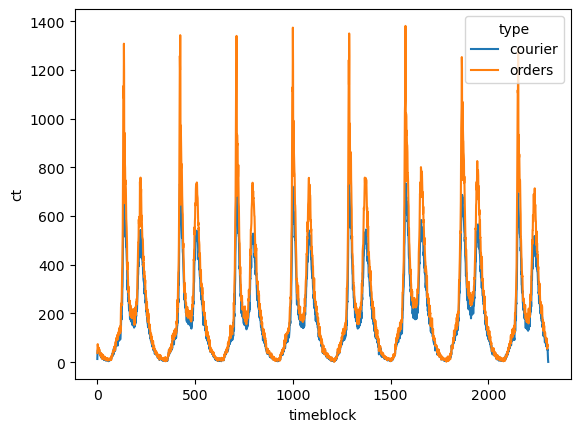

In [8]:
sns.lineplot(data=timeblock_data, x='timeblock', y='ct', hue='type')
plt.show()

In [9]:
timeblock_merge = timeblocks_courier.merge(timeblocks_orders[['timeblock','ct']].rename(columns={'ct':'order_ct'}), 
                    on='timeblock',
                    how='left')
timeblock_merge['courier_vs_order'] = timeblock_merge['ct']/timeblock_merge['order_ct']
timeblock_merge = timeblock_merge.dropna()

/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home1/yongpeng/.conda/envs/pyepo_dsl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


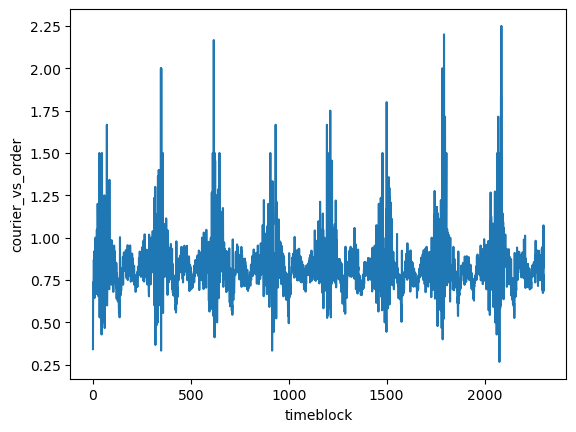

In [10]:
sns.lineplot(data=timeblock_merge, x='timeblock', y='courier_vs_order')
plt.show()

Courier Overlap Between Time Blocks

In [11]:
block_df = compare_chunk_id_overlap(df=chunked_courier, id_col="courier_id")
block_df[block_df.ids_ct > 100]['overlap_pct'].describe()

count    1337.000000
mean        0.205977
std         0.064469
min         0.056604
25%         0.161290
50%         0.198925
75%         0.244275
max         0.417404
Name: overlap_pct, dtype: float64

Matching

In [12]:
block_df[block_df.ids_ct > 500].head()

,timeblock,timeblock_start,ids_ct,next_timeblock,overlap_count,overlap_pct
132,132,2022-10-17 03:00:00,548,133.0,193,0.352190
133,133,2022-10-17 03:05:00,631,134.0,246,0.389857
134,134,2022-10-17 03:10:00,687,135.0,235,0.342067
135,135,2022-10-17 03:15:00,653,136.0,248,0.379786
136,136,2022-10-17 03:20:00,693,137.0,263,0.379509


In [13]:
chunked_courier.courier_id.nunique(), chunked_orders.order_id.nunique()

(4901, 568413)

In [14]:
tmp_courier = chunked_courier[chunked_courier.timeblock == 132].sort_values(by=['courier_id','time']).drop_duplicates(subset=['courier_id'], keep='first')
tmp_orders = chunked_orders[chunked_orders.timeblock == 132].sort_values(by=['order_id','time']).drop_duplicates(subset=['order_id'], keep='first')

min_num = min(tmp_courier.courier_id.nunique(),tmp_orders.order_id.nunique())
if len(tmp_courier) > min_num:
    tmp_courier = tmp_courier.sample(n=min_num, random_state=42)

if len(tmp_orders) > min_num:
    tmp_orders = tmp_orders.sample(n=min_num, random_state=42)

print(min_num)
#print(min_num, tmp_courier.courier_id.nunique(),tmp_orders.order_id.nunique())
#display(tmp_courier.head())
#display(tmp_orders.head())

548


In [15]:
start = time.time()
dist = haversine_distance_matrix(tmp_courier[['grab_lat','grab_lng']].values, tmp_orders[['sender_lat','sender_lng']].values)
row_ind, col_ind = linear_sum_assignment(dist)
end = time.time()
print(end - start, (end - start)*1000)

0.021771669387817383 21.771669387817383


In [16]:
matches = list(zip(row_ind, col_ind))
total_cost = dist[row_ind, col_ind].mean()
total_cost

948.9163979016282

# Successive Optimal Match

In [29]:
# courier
tmp_courier = chunked_courier[chunked_courier.timeblock.isin([132,133])].sort_values(by=['courier_id','time']).drop_duplicates(subset=['courier_id', 'timeblock'], keep='first')
full_courier = tmp_courier.loc[tmp_courier.timeblock == 132, ['courier_id', 'grab_lng', 'grab_lat']].merge(tmp_courier.loc[tmp_courier.timeblock == 133, ['courier_id', 'grab_lng', 'grab_lat']].rename(columns={'grab_lng':'grab_lng_2', 'grab_lat': 'grab_lat_2'}),
                                               how='outer', on='courier_id')

# Fill missing with dummy coords
full_courier[['grab_lng', 'grab_lat']] = full_courier[['grab_lng', 'grab_lat']].fillna(0)
full_courier[['grab_lng_2', 'grab_lat_2']] = full_courier[['grab_lng_2', 'grab_lat_2']].fillna(0)


# orders
tmp_orders = chunked_orders[chunked_orders.timeblock.isin([132,133])].sort_values(by=['order_id','time']).drop_duplicates(subset=['order_id'], keep='first')
orders = tmp_orders[tmp_orders['timeblock'] == 132].reset_index(drop=True)
orders_2 = tmp_orders[tmp_orders['timeblock'] == 133].reset_index(drop=True)

In [61]:
large_number = np.inf
# Compute distances for t
coords_A_t = full_courier[['grab_lat', 'grab_lng']].values
coords_B_t = orders[['sender_lat', 'sender_lng']].values
dist_t = haversine_distance_matrix(coords_A_t, coords_B_t)
dist_t[np.all(coords_A_t == 0, axis=1), :] = large_number

# Compute distances for t+1
coords_A_t1 = full_courier[['grab_lat_2', 'grab_lng_2']].values
coords_B_t1 = orders_2[['sender_lat', 'sender_lng']].values
dist_t1 = haversine_distance_matrix(coords_A_t1, coords_B_t1)
dist_t1[np.all(coords_A_t1 == 0, axis=1), :] = large_number

final_dist = np.concatenate([dist_t, dist_t1], axis=1)
match_reward = np.ceil(final_dist[final_dist != np.inf].max())
weights = -1*(match_reward - final_dist)

n, m = weights.shape
pad_rows = m - n
padded_weights = np.concatenate([weights, np.zeros((pad_rows, m))], axis=0)
padded_weights[np.isinf(padded_weights)] = 0


In [65]:
row_ind, col_ind = linear_sum_assignment(padded_weights)

In [77]:
# Keep only matchings from the real rows (0 to n-1)
matching = [(i, j) for i, j in zip(row_ind, col_ind) if i < n]
match_weights = padded_weights[row_ind, col_ind]
# Print matchings and total weight
#print("Matching:", matching)
print("Avg weight:", 50000+sum(weights[i, j] for i, j in matching)/n)


Avg weight: 3032.5170799021


In [85]:
(50000+match_weights[:n]).mean()

3032.517079902118

# Solve using MPAX

In [53]:
from mpax import create_lp, r2HPDHG, raPDHG
import jax
from jax import numpy as jnp

In [ ]:
# --- c ---
c = jnp.array(dist.flatten(), dtype=jnp.float32)

# --- A ---
# Index grid
n = dist.shape[0]
rows, cols = np.indices((n, n))
rows = rows.flatten()
cols = cols.flatten()

# Row constraints: for each i, sum x[i, j] over all j
A_eq_rows = np.zeros((n, n * n))
A_eq_rows[np.arange(n)[:, None], (rows * n + cols).reshape(n, n)] = 1  # shape (n, n^2)

# Column constraints: for each j, sum x[i, j] over all i
A_eq_cols = np.zeros((n, n * n))
A_eq_cols[np.arange(n)[:, None], (cols * n + rows).reshape(n, n)] = 1  # shape (n, n^2)

# Combine
A = np.vstack([A_eq_rows, A_eq_cols])  # shape (2n, n^2)
A = jnp.array(A, dtype=jnp.float32)

# --- b ---
b = jnp.ones(2 * n)

# --- bounds ---
l = jnp.zeros(n*n)      # lower bounds: all zero
u = jnp.ones(n*n)       # upper bounds: all one

# --- inequality empty ---
G = jnp.zeros((1, n*n))
h = jnp.zeros((1,),)

In [ ]:
c, A, b, G, h, l, u

In [30]:
solver.check_config(lp.is_lp)

In [33]:
lp.constraint_matrix

Array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
# Create LP using sparse matrix format (default)
# Create LP using dense matrix format

#what to do with G and h?
start = time.time()
lp = create_lp(c, A, b, G, h, l, u, use_sparse_matrix=False)
solver = r2HPDHG(eps_abs=1e-4, eps_rel=1e-4, verbose=False)
result = solver.optimize(lp)
end = time.time()
print(end - start, (end - start)*1000)

1.1872122287750244 1187.2122287750244
